## 1. Import Libraries

Necessary libraries to execute the code

In [ ]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

Matplotlib is building the font cache; this may take a moment.


## 2. Data Import
The following code cell is used to download the dataset files from the Kaggle website. It only needs to be executed once.  
Additionally, you will need to generate a personal Kaggle API Token in your account settings and install kaggle (pip install kaggle). 
In my case, when generating the Token, it was not automatically saved locally, so I created the json file manually and saved it in the .Kaggle folder in users. It follows this structure: 
{
    "username": "your_username",
    "key": "copy the API TOKEN the first time is generated, or not visible anymore"
}

In [6]:
def download_kaggle_dataset(dataset, path="data"):
     if not os.path.exists(path):
         os.makedirs(path)

     api = KaggleApi()
     api.authenticate()
     api.dataset_download_files(dataset, path=path, unzip=True)
     print("Dataset downloaded and extracted.")

if __name__ == "__main__":
    download_kaggle_dataset("barun2104/telecom-churn")

Dataset URL: https://www.kaggle.com/datasets/barun2104/telecom-churn
Dataset downloaded and extracted.


In [9]:
df=pd.read_csv('data/telecom_churn.csv')
print(df)
print("Dataset Columns: \n")
print(df.columns)

      Churn  AccountWeeks  ContractRenewal  DataPlan  DataUsage  \
0         0           128                1         1       2.70   
1         0           107                1         1       3.70   
2         0           137                1         0       0.00   
3         0            84                0         0       0.00   
4         0            75                0         0       0.00   
...     ...           ...              ...       ...        ...   
3328      0           192                1         1       2.67   
3329      0            68                1         0       0.34   
3330      0            28                1         0       0.00   
3331      0           184                0         0       0.00   
3332      0            74                1         1       3.70   

      CustServCalls  DayMins  DayCalls  MonthlyCharge  OverageFee  RoamMins  
0                 1    265.1       110           89.0        9.87      10.0  
1                 1    161.6       123 

**ATTRIBUTES DESCRIPTION**
- Churn = The target variable indicating whether a customer canceled their service (1 = Yes, 0 = No)
- AccountWeeks = The number of weeks the customer has had an active account with the telecom provider
- ContractRenewal = A binary indicator of recent loyalty (1 if the customer recently renewed their contract, and 0 if they did not)
- DataPlan = Indicates if the customer has a data plan (1 = Yes, 0 = No)
- DataUsage = The amount of mobile data used by the customer, typically measured in gigabytes (GB) per month
- CustServCalls = The total number of calls made by the customer to customer service; high numbers often correlate with dissatisfaction
- DayMins = The average number of minutes the customer spends on calls during daytime hours each month
- DayCalls = The average number of distinct calls made by the customer during daytime hours
- MonthlyCharge = The average monthly bill amount charged to the customer
- OverageFee = The highest overage fee recorded for the customer in the last 12 months due to exceeding plan limits
- RoamMins = The average number of minutes spent on roaming (calls made outside the home network area) per month


## Data Profiling
From this profiling we understand that we have 3332 rows of actual data (3333 considering the first row for attributes). We luckily don't have missing values nor duplicates. 

In [10]:
print("\nDataset Info: \n")
print(df.info())
print("\nMissing Values: \n")
print(df.isnull().sum()) 
print("\nDuplicate Values: \n")
print(df.duplicated().sum())
print("\nDescriptive Statistics:")
print(df.describe())


Dataset Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB
None

Missing Values: 

Churn              0
AccountWeeks       0
ContractRenewal    0
DataPlan           0
DataUsage          0
CustServCalls      0
DayMins            0
DayCalls           0
MonthlyCharge      0
OverageFee   

Instead of just spotting the insights in the descriptive statistics manually, we can exploit some Python libraries useful for Exploratory Data Analysis (EDA) as a bridge between descriptive statistics and ML workflow, such as *seaborn* and *matplotlib*. 

**1. VISUALIZE CLASS IMBALANCE (CHURN RATE)**
It matters because if the churn group is too small, the ML model might struggle to learn their behavior. In this context, around 500 items is enough if careful when choosing the evaluation method. If the behavior is clearly distinct, we can reveal it with algorithms like RandomForest or XGBoost, otherwise we risk that the model always guesses by saying that no one will churn. We can use some techniques to ensure the model correctly learns, like not using accuracy as primary metric for this dataset, but Recall (how many of the actual churners did we catch?) or F1-Score (a balance of catching churners without flagging too many happy customers), or attributing class weights via scikit-learn. 

Churn
0    85.508551
1    14.491449
Name: proportion, dtype: float64


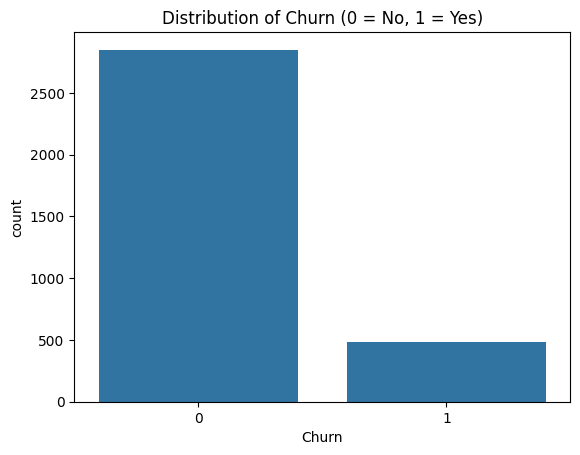

In [11]:
# Formula to see the exact counts and percentage
print(df['Churn'].value_counts(normalize=True) * 100)

sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn (0 = No, 1 = Yes)')
plt.show()

**2. IDENTIFY CORRELATIONS**
We can verify which attributes are most connected to the churn without checking each one manually with a heatmap.
Of course, we get some trivial insights, such as a positive and strong correlation between DataUsage and DataPlan or DataUsage and MonthlyCharge. 
With a combination of data filtering and correlation analysis, we can find some deeper insights to verify important correlations with the churn tendency (*see after the heatmap*)

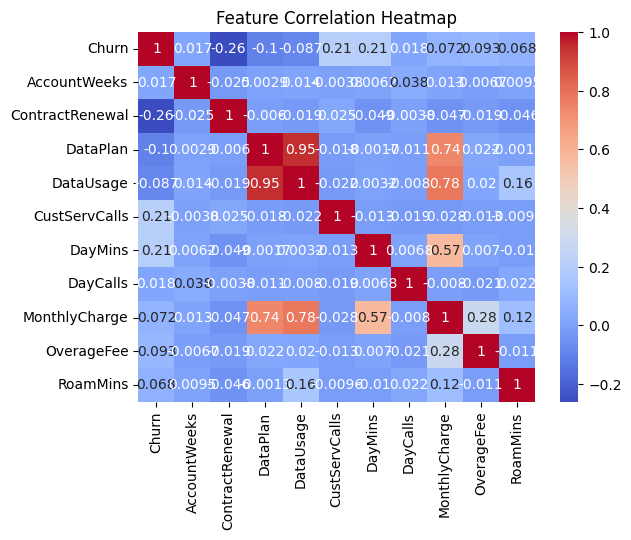

In [ ]:
# Formula to see which features relate most to Churn
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [14]:
# Step 1: Filter the dataframe for only loyal customers (Churn == 0)
loyal_customers = df[df['Churn'] == 0]

# Step 2: Select the 'CustServCalls' column from that group and find the mean
avg_calls = loyal_customers['CustServCalls'].mean()

print("Average of Calls made by loyal customers (no churn): ", round(avg_calls,2))

Average of Calls made by loyal customers (no churn):  1.45


In [15]:
# Do the inverse for customers that quit
churned_customers = df[df['Churn'] == 1]
avg_calls = churned_customers['CustServCalls'].mean()
print ("Average of Calls made by churned customers (no churn): ", round(avg_calls,2))

Average of Calls made by churned customers (no churn):  2.23


If CustServCalls has a correlation of 0.21 with Churn, it means as calls increase, the likelihood of churn also increases. It might seem a small number in absolute terms, but it is an interesting finding for this type of data, also because it is the highest we can find in relation to churn in the matrix. The value 1.45 is the mean of the CustServCalls column, but only for the rows where the customer did not churn. Correlation measures the linear strength of the relationship across the entire dataset, but the averages tell the story of the groups, because the 2.23 instead underlines a 54% increase in the in call volume for the churn group, so the correlation is numerically low but the physical reality is still impactiful. 